In [1]:
%cd ../../../

/home/noahb/workspace/uwnet


In [2]:
from src.data import open_data
from uwnet.wave import LinearResponseFunction, WaveEq, base_from_xarray, model_plus_damping
import torch

import xarray as xr

import numpy as np

from uwnet.thermo import ngaqua_y_to_lat
import matplotlib.pyplot as plt

plt.rcParams['savefig.dpi'] = 150

In [3]:
model_path = "nn/NNAll/20.pkl"

mean = open_data('mean')
mean['rho'] = open_data('density')
mean['lat'] = ngaqua_y_to_lat(mean.y)

# need to wrap with this class or it fails
model = model_plus_damping(torch.load(model_path).eval())

def compute_lrf(loc):
    mean = loc.mean('y')
    base_state = base_from_xarray(mean)
    return LinearResponseFunction.from_model(model, base_state)


# compute lrfs in 7 different abs(lat) bins
bins = 7
lrfs = {y.mid: compute_lrf(loc) for y, loc in mean.groupby_bins(np.abs(mean.lat), bins=bins)}

def plot_vary_lat(lrfs, ink, out):

    n = len(lrfs)
    p = mean.p.values
    fig, axs = plt.subplots(1, bins, figsize=(10, 2), sharex=True, sharey=True)

    for ax, (latitude, lrf) in zip(axs.flat, lrfs.items()):
        im = ax.pcolormesh(p, p, 86400*lrf.panes[out][ink], vmax=1, vmin=-1, cmap='RdBu_r')
        ax.text(1000, 10, "lat = %.1f"%latitude)
        
    fig.colorbar(im, ax=axs.tolist(), pad=.001)
    ax.invert_yaxis()
    ax.invert_xaxis()

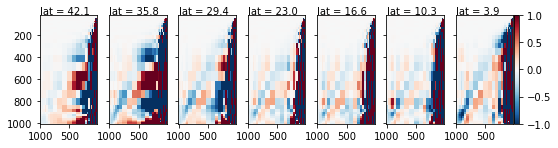

In [4]:
plot_vary_lat(lrfs, 'q', 'q')

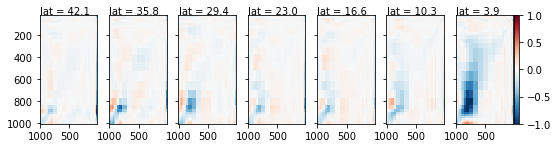

In [5]:
plot_vary_lat(lrfs, 's', 's')

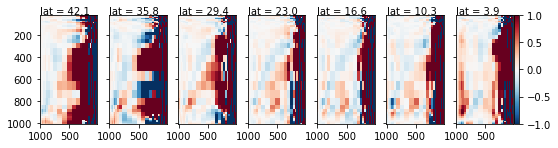

In [6]:
plot_vary_lat(lrfs, 'q', 's')

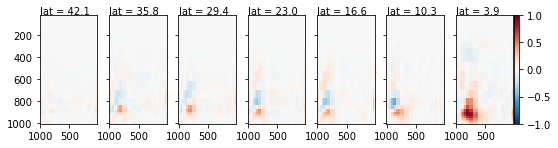

In [7]:
plot_vary_lat(lrfs, 's', 'q')